## datacollector.ipynb

This notebook has two functions:
- Generating training data (teleop control)
- Running a trained model

The first section of this notebook sets up the VR enviornment.  It must be run regardless of which of these tasks you'd like to do.

# Core section (run this part if you want to do either task)

In [1]:
import pybullet
import time
import pybullet_data
import pybullet_robots
import math
import numpy as np
import threading
import matplotlib.pyplot as plt
import cv2
import os
import csv
%matplotlib inline

In [3]:
#setup constants

#width and height for rgb and depth image
IMG_WIDTH = 160
IMG_HEIGHT = 120

#robot constants
NUM_JOINTS = 6
FINGER_AXES = [4, 6]

#data record path
DATA_PATH = "data"

In [4]:
#setup global variables
runNumber = 0 #folder number to save data

In [5]:
usingVR = True

#setup the simulation
if usingVR:
    physics = pybullet.connect(pybullet.SHARED_MEMORY)
    if (physics<0):
        print('could not use vr!')
    else:
        print('using vr')
else:
    physics = pybullet.connect(pybullet.GUI)

#add a plane to the simulation
pybullet.setAdditionalSearchPath(pybullet_data.getDataPath())
print(pybullet_data.getDataPath())

using vr
c:\Users\Ronak\anaconda3\envs\torch\lib\site-packages\pybullet_data


For VR to work, you must compile bullet3 with VR support and run "App_SharedMemoryPhysics_VR" as described here: https://github.com/bulletphysics/bullet3

After you compile this and launch the App_SharedMemoryPhysics_VR.exe file, the above cell should say "using vr" .  Make sure this output is produced before continuing.

In [6]:
def getRandomPos(x_range = [-0.6, -0.2], y_range = [-0.2, 0]):
        x = np.random.uniform(x_range[0], x_range[1])
        y = np.random.uniform(y_range[0], y_range[1])
        return [x, y, 0.7]

def reset():
    # clear all the objects in the simulation
    pybullet.resetSimulation()
    plainId = pybullet.loadURDF("plane.urdf", [0, 0, 0], useFixedBase=True)

    # #add a table in front of the robot arm
    tableId = pybullet.loadURDF("table/table.urdf", basePosition=[0,0,0])

    #add misc objects to the simulation on the table
    pybullet.loadURDF("lego/lego.urdf", basePosition=[-0.6,-0.2,0.7], globalScaling=2.5)

    pybullet.loadURDF("tray/traybox.urdf", basePosition=[0.1, -0.3, 0.65], globalScaling=0.5)

    #add a robot arm to the simulation
    robotId = pybullet.loadURDF("kuka_iiwa/model_vr_limits.urdf", [-0,0.3,0.6], useFixedBase=True)
    kuka_gripper_id = pybullet.loadSDF("gripper/wsg50_one_motor_gripper_new_free_base.sdf")[0]
    # attach gripper to kuka arm
    kuka_cid = pybullet.createConstraint(robotId, 6, kuka_gripper_id, 0, pybullet.JOINT_FIXED, [0, 0, 0], [0, 0, 0.05], [0, 0, 0])
    kuka_cid2 = pybullet.createConstraint(kuka_gripper_id, 4, kuka_gripper_id, 6, jointType=pybullet.JOINT_GEAR, jointAxis=[1,1,1], parentFramePosition=[0,0,0], childFramePosition=[0,0,0])
    pybullet.changeConstraint(kuka_cid2, gearRatio=-1, erp=0.5, relativePositionTarget=0, maxForce=100)
    # robotId = pybullet.loadURDF("kuka_iiwa/model.urdf", [-0,0.3,0.6], useFixedBase=True)
    #set the arm to an experimentally good starting position
    # reset kuka
    jointPositions = [-0.000000, -0.000000, 0.000000, 1.570793, 0.000000, -1.036725, 0.000001]
    for jointIndex in range(pybullet.getNumJoints(robotId)):
        pybullet.resetJointState(robotId, jointIndex, jointPositions[jointIndex])
        pybullet.setJointMotorControl2(robotId, jointIndex, pybullet.POSITION_CONTROL, jointPositions[jointIndex], 0)

    # reset gripper
    pybullet.resetBasePositionAndOrientation(kuka_gripper_id, [0.923103, -0.200000, 1.250036], [-0.000000, 0.964531, -0.000002, -0.263970])
    jointPositions = [0.000000, -0.011130, -0.206421, 0.205143, -0.009999, 0.000000, -0.010055, 0.000000]
    for jointIndex in range(pybullet.getNumJoints(kuka_gripper_id)):
        pybullet.resetJointState(kuka_gripper_id, jointIndex, jointPositions[jointIndex])
        pybullet.setJointMotorControl2(kuka_gripper_id, jointIndex, pybullet.POSITION_CONTROL, jointPositions[jointIndex], 0)

    num_joints = pybullet.getNumJoints(robotId)
    kuka_end_effector_idx = 6
    #set the gravity
    pybullet.setGravity(0, 0, -10)

    # create a thread to run the simulation
    pybullet.setRealTimeSimulation(1)
    
    return robotId,kuka_gripper_id

robotId,kuka_gripper_id = reset()

In [7]:
#Helper functions for controlling the robot arm
isGrabberOpen = False
def openGrabber():
    global isGrabberOpen
    global kuka_gripper_id
    pybullet.setJointMotorControl2(kuka_gripper_id, 4, pybullet.POSITION_CONTROL, targetPosition=0.05, force=100)
    pybullet.setJointMotorControl2(kuka_gripper_id, 6, pybullet.POSITION_CONTROL, targetPosition=0.05, force=100)
    isGrabberOpen = True

def closeGrabber():
    global isGrabberOpen
    global kuka_gripper_id
    pybullet.setJointMotorControl2(kuka_gripper_id, 4, pybullet.POSITION_CONTROL, targetPosition=0, force=100)
    pybullet.setJointMotorControl2(kuka_gripper_id, 6, pybullet.POSITION_CONTROL, targetPosition=0, force=100)
    isGrabberOpen = False

def setEndEffectorPos(pos, orientation):
    #first get desired joint positions via inverse kinematics
    jointPoses = pybullet.calculateInverseKinematics(robotId, 6, pos, orientation)
    for i in range(len(jointPoses)):
        if i in FINGER_AXES:
            continue
            
        pybullet.setJointMotorControl2(robotId, i, pybullet.POSITION_CONTROL, targetPosition=jointPoses[i], force=100)

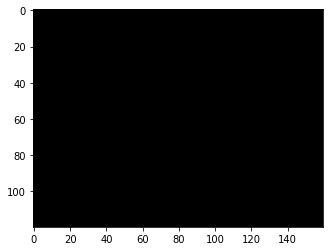

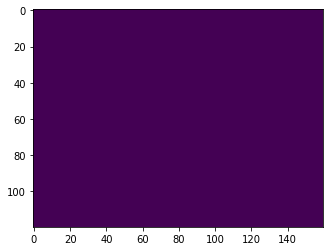

In [8]:
reset()
def getIsOpen():
    global isGrabberOpen
    return isGrabberOpen

def getPointsOnEndEffector(visualize=False):
    linkNum = 6
    #cet center position
    endEffectorPos, endEffectorOrn = pybullet.getLinkState(robotId, linkNum)[:2]
    #use orientation to compute the other two points
    rotMat = pybullet.getMatrixFromQuaternion(endEffectorOrn)
    rotMat = np.array(rotMat).reshape(3,3)
    localPos = np.array([0, 0.2, 0])
    endEffectorPos2 = endEffectorPos + rotMat.dot(localPos)
    localPos = np.array([0.2, 0, 0])
    endEffectorPos3 = endEffectorPos + rotMat.dot(localPos)

    endState = np.array(endEffectorPos)
    endState = np.append(endState, pybullet.getEulerFromQuaternion(endEffectorOrn))

    if visualize:
        #add small spheres to visualize the points
        pybullet.addUserDebugLine(endEffectorPos, endEffectorPos2, [1,0,0], 1, 0.1)
        pybullet.addUserDebugLine(endEffectorPos, endEffectorPos3, [0,1,0], 1, 0.1)
    
    return [endEffectorPos, endEffectorPos2, endEffectorPos3], endState

def getTrainingData():
    '''return everything in a timestep needed for training (rgb img, depth mask, end effector pos, finger open)
    '''

    viewMatrix = pybullet.computeViewMatrixFromYawPitchRoll(cameraTargetPosition=[0,0,0.5], distance=1.1, yaw=0, pitch=-45, roll=0, upAxisIndex=2)
    projectionMatrix = pybullet.computeProjectionMatrixFOV(fov=60, aspect=float(IMG_WIDTH)/IMG_HEIGHT, nearVal=0.1, farVal=100.0)
    image = pybullet.getCameraImage(IMG_WIDTH, IMG_HEIGHT, viewMatrix=viewMatrix, projectionMatrix=projectionMatrix, shadow=1, lightDirection=[1,1,1], lightColor=[1,1,1], lightDistance=1, lightAmbientCoeff=0.5, lightDiffuseCoeff=0.5, lightSpecularCoeff=0.5, renderer=pybullet.ER_BULLET_HARDWARE_OPENGL, flags=pybullet.ER_NO_SEGMENTATION_MASK)

    #show the image in frame
    width = image[0]
    height = image[1]
    rgb = image[2]
    depth = image[3]
    segmentation = image[4]

    #convert to numpy array
    rgb = np.reshape(rgb, (height, width, 4))
    rgb = rgb[:, :, :3] #remove alpha channel
    
    depth = np.reshape(depth, (height, width))

    #get the 3 points on the end effector
    endEffectorPoints, endState = getPointsOnEndEffector()

    #get if the grabber is open
    isOpen = getIsOpen()
    
    return rgb, depth, endEffectorPoints, endState, isOpen

#visualize sample image
rgb, depth, endEffectorPoints, endState, isOpen = getTrainingData()
plt.imshow(rgb)
plt.show()
plt.imshow(depth)
plt.show()

# End of Core Env Setup Functions.

Run this next section to create training data.  Make sure you have an empty /data/ folder in the same directory as this notebook before proceeding.

If you just want to run an existing model, skip to the "running a model" section.

In [9]:
isCollectingImgs = False
def continuousRecordImgs10Hz():
    global runNumber
    rgbImgs = []
    depthImgs = []
    points = []
    opens = []
    endStates = []
    while isCollectingImgs:
        startTime = time.time()
        rgb, depth, endEffectorPoints, endState, isOpen = getTrainingData()
        rgbImgs.append(rgb)
        depthImgs.append(depth)
        points.append(endEffectorPoints)
        endStates.append(endState)
        opens.append(isOpen)
        endTime = time.time()
        sleepTime = 0.1 - (endTime - startTime)
        if sleepTime > 0:
            time.sleep(sleepTime)
        else:
            print("Warning: Data collection is too slow, took", endTime - startTime, "seconds to collect one image")
    
    #save the images
    dataPath = f"{DATA_PATH}/{runNumber}"
    os.mkdir(dataPath)
    rgbPath = f"{dataPath}/rgb"
    depthPath = f"{dataPath}/depth"
    statePath = f"{dataPath}/states"
    os.mkdir(rgbPath)
    os.mkdir(depthPath)
    os.mkdir(statePath)

    for i in range(len(rgbImgs)):
        #convert to bgr for opencv
        bgr = rgbImgs[i][:, :, ::-1]
        cv2.imwrite(f"{rgbPath}/rgb{i}.png", bgr)
    
    for i in range(len(depthImgs)):
        #convert to int
        img = (depthImgs[i] * 255).astype(np.uint8)
        cv2.imwrite(f"{depthPath}/depth{i}.png", img)

    #create a csv file with the points and opens for each time step
    for i in range(len(points)):
        with open(f"{statePath}/states{i}.csv", "w") as f:
            f.write(f'{points[i][0][0]},{points[i][0][1]}')
            f.write(f',{points[i][1][0]},{points[i][1][1]}')
            f.write(f',{points[i][2][0]},{points[i][2][1]}')
            if opens[i]:
                f.write(",1")
            else:
                f.write(",0")
            f.write('\n')
            f.write(f'{endStates[i][0]},{endStates[i][1]},{endStates[i][2]},{endStates[i][3]},{endStates[i][4]},{endStates[i][5]}')      

def stopRun():
    global runNumber
    global isCollectingImgs

    #stop data collection for this run
    isCollectingImgs = False
    time.sleep(0.2) #wait for the thread to stop

def startNextRun():
    global runNumber
    global isCollectingImgs
    #start the next run
    runNumber += 1
    isCollectingImgs = True
    thread = threading.Thread(target=continuousRecordImgs10Hz)
    thread.start()

In [10]:
isRunning = True
# pybullet.setVRCameraState(trackObject=robotId)
def updateControllerContinuously():
    global robotId
    lastButtonState = np.zeros(6)
    # startNextRun()
    while isRunning:
        #get the position and orientation of the controller
        controllerId = 2
        controllerState = pybullet.getVREvents()
        for controllerState in controllerState:
            id = controllerState[0]
            pos = controllerState[1]
            orientation = controllerState[2]

            if id is not controllerId:
                continue

            #rotate orientation by 90 degrees in the x axis
            orientation = pybullet.getEulerFromQuaternion(orientation)
            orientation = list(orientation)
            orientation[0] += math.pi
            orientation = pybullet.getQuaternionFromEuler(orientation)
            
            setEndEffectorPos(pos, orientation)

            #convert to tuple
            orientation = list(orientation)
            # controllerState[6][33] front trigger ,controllerState[6][34] side trigger
            #if trigger is pressed, close the grabber
            if controllerState[6][33] == 1:
                closeGrabber()
            else:
                openGrabber()
            buttons = controllerState[6]
            #check for menu button
            # if buttons[34] == 4:
                #reset environment
                # stopRun()
                # time.sleep(1) #stop mid-reset pictures from being recorded
                # robotId = reset()
                # time.sleep(1)
                # startNextRun()
            # else:
                # print(buttons[1], lastButtonState[1])
            lastButtonState = buttons

#start the controller thread
thread = threading.Thread(target=updateControllerContinuously)
thread.start()

In [ ]:
#kill the thread
isRunning = False
isCollectingImgs = False

In [ ]:
while True:
    time.sleep(1)
    controllerState = pybullet.getVREvents()
    print()

In [ ]:
print(controllerState[0][3])

The next cell kills the pybullet simulation

In [ ]:
print(controllerState[0][6])

In [ ]:
#close the simulation
pybullet.disconnect()

# Running a pre-trained model.

The next few cells load a model.pt file and run it on the environment

In [ ]:
# control the robot arm with a deep learning model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [ ]:
from VRNet import VRNet
from VRNet import DataPreprocessor

In [ ]:
#load the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = VRNet().to(device)
model.load_state_dict(torch.load("model.pt"))
model.eval()

#setup data preprocesser

# rgb mean:  tensor([0.5231, 0.5100, 0.4927])
# rgb std:  tensor([0.1867, 0.2083, 0.2512])
# depth mean:  tensor([0.8959])
# depth std:  tensor([0.0430])
# states mean:  tensor([ 0.0081, -0.0053,  0.0088,  0.0304,  0.0053,  0.0292,  0.5139],
#        device='cuda:0')
# states std:  tensor([0.0215, 0.0279, 0.0781, 0.3493, 0.0188, 0.1732, 0.4998],
#        device='cuda:0')


preprocessor = DataPreprocesser(rgb_mean=torch.tensor([0.5231, 0.5100, 0.4927]), rgb_std=torch.tensor([0.1867, 0.2083, 0.2512]), depth_mean=torch.tensor([0.8959]), depth_std=torch.tensor([0.0430]), \
                        state_mean=torch.tensor([ 0.0081, -0.0053,  0.0088,  0.0304,  0.0053,  0.0292,  0.5139]), state_std=torch.tensor([0.0215, 0.0279, 0.0781, 0.3493, 0.0188, 0.1732, 0.4998]))

This next cell creates the model robot controller thread.  After running it, the robot should start moving.  The included model can't get to the cube automatically, but once the robot reaches the cube, the model can place it on the tray.  This failure is likely because of the model simplifications (no auxiliary loss)

In [ ]:
def getCurrentEndEffectorPose():
    global robotId
    pos, orientation = pybullet.getLinkState(robotId, 8, computeForwardKinematics=False)[0:2]
    z_off = 0.04
    pos = [pos[0], pos[1], pos[2] + z_off]
    return pos, orientation

#in a separate thread, continuously update the robot arm with the model
modelControllingRobot = True
vels = []
def updateRobotNN():
    startTime = time.time()
    rgb, depth, _, _, _ = getTrainingData()

    rgb = torch.from_numpy(rgb).permute(2, 0, 1)
    depth = torch.from_numpy(depth)
    rgb = rgb.unsqueeze(0).to(device).float() / 255
    depth = depth.unsqueeze(0).unsqueeze(0).to(device).float()

    #show images with matplotlib
    # plt.imshow(rgb[0].permute(1, 2, 0).detach().cpu().numpy())
    # plt.show()
    # plt.imshow(depth[0].detach().cpu().numpy())
    # plt.show()

    rgb_norm = preprocessor.normalizeRgb(rgb.cpu()).to(device)
    depth_norm = preprocessor.normalizeDepth(depth.cpu()).to(device)
    y = model(rgb_norm, depth_norm)

    #convert the output to a list of velocities
    outputs = y.detach().cpu()
    outputs = preprocessor.denormalizeState(outputs)
    outputs = outputs[0].numpy()
    
    Vx, Vy, Vz, Wx, Wy, Wz, grabberOpen = outputs

    #compute the next position of the end effector in 100 ms
    pos, orn = getCurrentEndEffectorPose()
    x, y, z = pos
    
    x += Vx * 0.5 #use 0.5 instead of 0.1 to make the robot move faster for demos
    y += Vy * 0.5
    z += Vz * 0.5
    # roll += Wx * 0.01 #for simplicity, no angular control
    # pitch += Wy * 0.01
    # yaw += Wz * 0.01
    # vels.append([Vx, Vy, Vz, rgb[0].permute(1, 2, 0).detach().cpu().numpy()])

    pos = np.array([x, y, z])
    orn = pybullet.getQuaternionFromEuler([0, math.pi, -math.pi/1.7])

    #move the robot arm to the next position
    setEndEffectorPos(pos, orn)

    #open or close the grabber
    if grabberOpen > 0.5:
        openGrabber()
    else:
        closeGrabber()
    
    dt = time.time() - startTime
    if dt < 0.1:
        time.sleep(0.1 - dt)
    else:
        print("Warning: updateRobotNN took too long: ", dt)

def updateRobotContinuous():
    while modelControllingRobot:
        updateRobotNN()

#start the thread
thread = threading.Thread(target=updateRobotContinuous)
thread.start()

Close the robot controller thread

In [ ]:
modelControllingRobot = False
reset()